Задачи:

1. Посчитайте среднее количество показов и среднее количество кликов по объявления за весь период (округлите до целых).

2. Нарисуйте график распределения показов на объявление за весь период
   По оси x – число показов
   По оси y – доля объявлений с такими показами
   
3. Посчитайте среднее количество просмторов на одно объявление по дням

4. Скользящее среднее часто используется для поиска аномалий в данных. Нанести на один график значения                              арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по      модулю между арифметическим средним и скользящим средним?

5. Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым      запуском рекламного объявления этим клиентом.

6. Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в            процентах и округлите до сотых.

7. Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления и 



In [56]:
# подкулючаем библиотеки для анализа данных
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
# считываем данные
df = pd.read_csv("/home/jupyter-m-vosorov/shared/homeworks/python_ds_miniprojects/6/ads_data.csv")

In [5]:
# Преобразуем временные поля в более удобный для работы тип данных
df["date"] = pd.to_datetime(df["date"])
df["time"] = pd.to_datetime(df["time"])

In [6]:
# Задача 1: Посчитаем среднее количество показов и среднее количество кликов по объявления за весь период

# Отдельно считаем среднее для просмторов и кликов, далее выводим
click = df.groupby(["ad_id", "event"], as_index = False) \
          .agg({"client_union_id" : "count"}) \
          .rename(columns = {"client_union_id" : "number"}) \
          .pivot(index = "ad_id", columns = "event", values = "number") \
          .fillna(0).reset_index().click.mean().round()

view = df.groupby(["ad_id", "event"], as_index = False) \
         .agg({"client_union_id" : "count"}) \
         .rename(columns = {"client_union_id" : "number"}) \
         .pivot(index = "ad_id", columns = "event", values = "number") \
         .fillna(0).reset_index().view.mean().round()

print(f"Mean number of advertisment views is {view}")
print(f"Mean number of advertisment clicks is {click}")

Mean number of advertisment views is 923.0
Mean number of advertisment clicks is 113.0


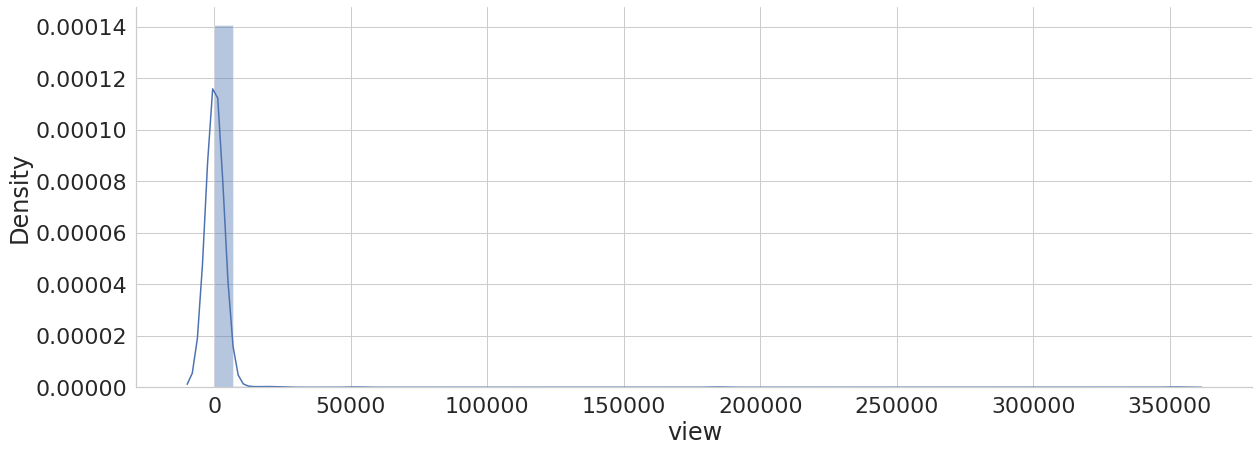

In [7]:
# Задача 2: Нарисуем график распределения показов на объявление за весь период

view_dist = df \
                .groupby(["ad_id", "event"], as_index = False) \
                .agg({"client_union_id" : "count"}) \
                .rename(columns = {"client_union_id" : "number"}) \
                .pivot(index = "ad_id", columns = "event", values = "number") \
                .fillna(0).reset_index()
view_dist = view_dist[view_dist.view != 0] # убираем строки с багами просмотров

# Настраиваем график и рисуем график
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

sns.distplot(view_dist["view"])
sns.despine()
# Как видно такой график не очень информативен, и плохо подходит для статистических тестов, поэтому мы логарифмируем просмторы

In [8]:
# Задача 2, продолжение

def lg(num): # функция для логарифмирования
    return np.log(num)

view_dist["view"] = view_dist["view"].apply(log)
sns.distplot(view_dist["view"])
sns.despine()
# Такое распределение гораздо больше похоже на нормальное

NameError: name 'log' is not defined

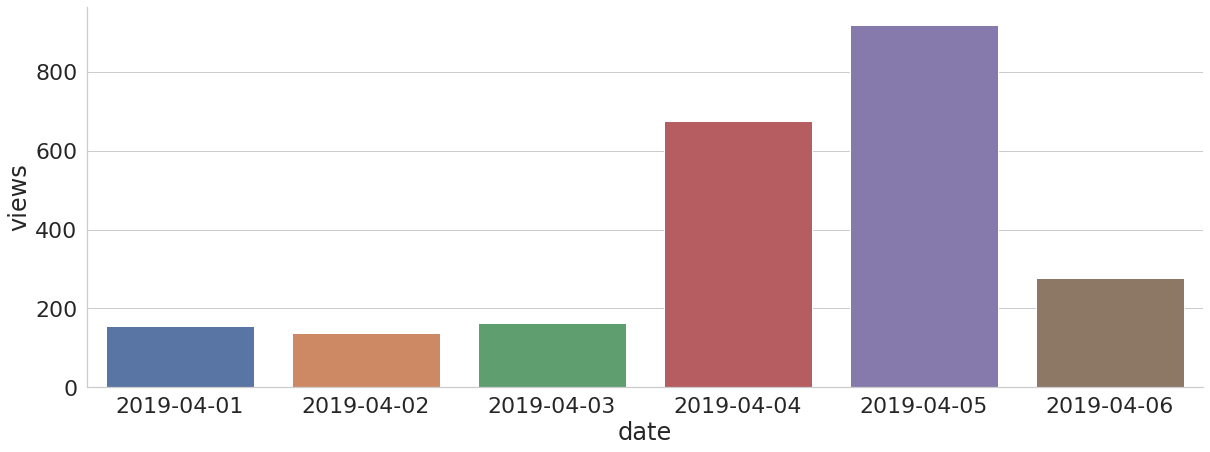

In [9]:
# Задача 3: Посчитаем среднее количество просмторов на одно объявление по дням

view_by_day = df \
                  .query("event == 'view'") \
                  .groupby(["date", "ad_id"], as_index = False) \
                  .agg({"event" : "count"}) \
                  .groupby("date", as_index = False) \
                  .agg({"event" : "mean"}) \
                  .rename(columns = {"event" : "views"})
view_by_day['date'] = pd.to_datetime(view_by_day['date']).dt.date

# Для наглядности построим график
sns.barplot(data = view_by_day, x = view_by_day["date"], y = view_by_day["views"])
sns.despine()



    

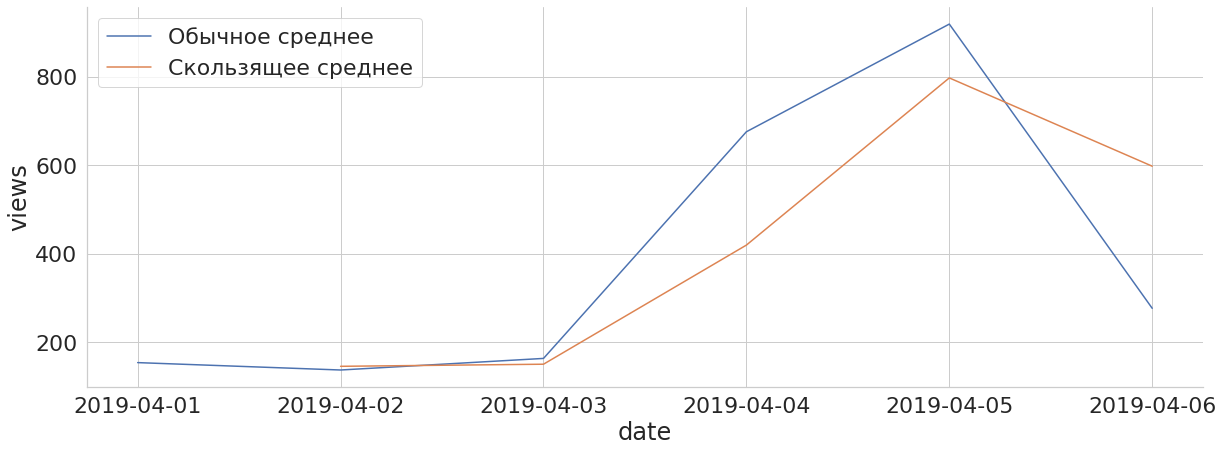

In [10]:
# Задача 4: Давайте попробуем найти аномалию в данных используя скользящее среднее, и данные полученные в прошлой задаче

# Считаем тоже самое что и предыдущей задаче, только использую скользящее среднее
views_rolling = df \
                  .query("event == 'view'") \
                  .groupby(["date", "ad_id"], as_index = False) \
                  .agg({"event" : "count"}) \
                  .groupby("date") \
                  .agg({"event" : "mean"}) \
                  .rename(columns = {"event" : "views"}) \
                  .views.rolling(2).mean().reset_index().drop(index = 0)

sns.lineplot(data = view_by_day,x = view_by_day["date"], y =view_by_day["views"], label = "Обычное среднее")
sns.lineplot(data = views_rolling, x = views_rolling["date"], y = views_rolling["views"], label = "Скользящее среднее")
sns.despine()
# Как мы видим, наибольшая разница между двумя средними наблюдается 2019-04-06

In [11]:
# Задача 5:  Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней
# от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

ads_clients = pd.read_csv("/home/jupyter-m-vosorov/shared/homeworks/python_ds_miniprojects/6/ads_clients_data.csv")

# Переводим временные данные в более удобный для работы формат
ads_clients["date"] = pd.to_datetime(ads_clients["date"])
ads_clients["create_date"] = pd.to_datetime(ads_clients["create_date"])
ads_clients = ads_clients.rename(columns = {"date" : "regist_date"})

# Объединяем рекламные данные с данными по рекламным клиентам

full_df = df.merge(ads_clients, on = "client_union_id", how = "inner")

# Создаем колонку с разницей, между созданием объявления и регистрацией рекламного клиента
full_df["delay_days"] = full_df["date"] - full_df["create_date"]

# Теперь сгрупируем разницу дат для каждго клиента, найдем разницу дат между первым объявлением и регистрацией, и посчитаем
# среднюю разницу по всем клиентам
full_df.groupby("client_union_id", as_index = False).agg({"delay_days" : "min"}).delay_days.mean()

# Как мы видим, в среднем рекламодатели тратят 124 дня между регистрацией и первым своим рекламным объявлением

Timedelta('124 days 09:04:43.532219570')

In [37]:
# Задача 6: Найдем процент клиентов, которые за 365 дней после регистрации, разместили хоть одно обьявление

# Для начала поймем, что в объединённую таблицу попали только те клиенты, которые разместили хоть одну рекламу
# После понимания, посчитаем, какое максимально количество дней среди всех клиентов прошло между регистрацией и объявлением
print(full_df.delay_days.max())

252 days 00:00:00


In [36]:
# Интересно, получается, что все клиенты, которые разместили рекламу, сделали это в течении года после регистрации
# Узнаем количество клиентов, разместивших рекламу
print(full_df.client_union_id.nunique())

# Таких клиентов у нас всего 838, осталось узнать сколько у нас всего клиентов

838


In [38]:
# Узнаем сколько у нас всего клиентов из таблички с информацией о клиентах
print(ads_clients.client_union_id.nunique())

122078


In [39]:
# Осталось посчитать и округлить процент "активных" клиентов
print(round((838 / 122078) * 100, 2))
# Это и есть конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов.

0.69


In [64]:
# Задача 7: Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

# Построим интерактивный график, на котором будут показаны клиенты, разместившие своё первое объявление, разбитые по категориям

first_ads = full_df \
                .groupby("client_union_id", as_index = False) \
                .agg({"delay_days" : "min"})
first_ads["delay_categorical"] = pd.cut(first_ads["delay_days"], [
                                                              pd.to_timedelta("0 days 00:00:00"),
                                                              pd.to_timedelta("30 days 00:00:00"),
                                                              pd.to_timedelta("90 days 00:00:00"),
                                                              pd.to_timedelta("180 days 00:00:00"),
                                                              pd.to_timedelta("365 days 00:00:00")],
                                                              labels = ["30", "30-90", "90-180", "180-365"])

categories = first_ads \
                 .groupby("delay_categorical", as_index = False) \
                 .agg({"delay_days" : "count"}) \
                 .rename(columns = {"delay_days" : "count", "delay_categorical" : "category"})

px.bar(categories, x = "category", y = "count")